In [1]:
import pandas as pd #Must be using an older version of Pandas due to compatability issues with the anomaly detectors
import matplotlib.pyplot as plt
import numpy as np

#Anomaly detection:
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import PersistAD
'''Detector that detects anomaly based on values in a preceding period.

This detector compares time series values with the values of their preceding time windows,
and identifies a time point as anomalous if the change of value from its preceding average
 or median is anomalously large.
 '''

'Detector that detects anomaly based on values in a preceding period.\n\nThis detector compares time series values with the values of their preceding time windows,\nand identifies a time point as anomalous if the change of value from its preceding average\n or median is anomalously large.\n '

#### Regional CBA and PBA 

In [2]:
#Importing both accounts
D_pba_reg = pd.read_csv('summary\D_pba_reg.csv',sep='\t',index_col=[0])
D_cba_reg = pd.read_csv('summary\D_cba_reg.csv',sep='\t',index_col=[0])

Only the industry-by-industry classification is used in this study.

In [3]:
''' Industry by industry dataframe '''
D_pba_reg_ixi = D_pba_reg.loc[D_pba_reg['system'] == 'ixi']
D_cba_reg_ixi = D_cba_reg.loc[D_cba_reg['system'] == 'ixi']

In [4]:
''' The function produces a dataframe of a region's stressors for the time frame available (1995-2022). '''
def time_series(cba, region):
    df = cba.loc[cba['region'] == region] #cba being either the pxp or ixi dataframe (also pba)
    return df

In [5]:
#Global
D_cba_GLOBAL = time_series(D_cba_reg_ixi,'global')
D_pba_GLOBAL = time_series(D_pba_reg_ixi,'global')

#The United States:
D_cba_USA = time_series(D_cba_reg_ixi,'US')
D_pba_USA = time_series(D_pba_reg_ixi,'US')

#The EU
D_cba_EU27 = time_series(D_cba_reg_ixi,'EU27')
D_pba_EU27 = time_series(D_pba_reg_ixi,'EU27')

#China
D_cba_CHINA = time_series(D_cba_reg_ixi,'CN') #In exiobase CH is the code for Switzerland. CN is China!
D_pba_CHINA = time_series(D_pba_reg_ixi,'CN')

In [6]:
#Normalization function, used throughout the study
def normalize(time_series, ref_point):
    return time_series/ref_point #ref point is supposed to be 1995

##### Anomaly detection setup

In [7]:
#The detection package is depentant on DatetimeIndex, so years must be converted to that object type
global_co2 = D_cba_GLOBAL.loc[:,'Total CO2'].to_numpy()
date_time_years = pd.to_datetime(D_cba_GLOBAL.index, format='%Y')

In [8]:
#This is the module used for the anomaly detection
persist_ad = PersistAD(c=1) #c --> factor used to determine the bound of normal range based on historical interquartile range

In [9]:
#This function detects every needed anomaly
def detect_anomaly(impact):
    globCBA = pd.DataFrame(D_cba_GLOBAL.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', the World'])
    UsaCBA = pd.DataFrame(D_cba_USA.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', USA'])
    EuCBA = pd.DataFrame(D_cba_EU27.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', EU27'])
    ChinaCBA = pd.DataFrame(D_cba_CHINA.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', China'])

    globPBA = pd.DataFrame(D_pba_GLOBAL.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', the World'])
    UsaPBA = pd.DataFrame(D_pba_USA.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', USA'])
    EuPBA = pd.DataFrame(D_pba_EU27.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', EU27'])
    ChinaPBA = pd.DataFrame(D_pba_CHINA.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', China'])

    globCBA = validate_series(globCBA)
    UsaCBA = validate_series(UsaCBA)
    EuCBA = validate_series(EuCBA)
    ChinaCBA = validate_series(ChinaCBA)

    globPBA = validate_series(globPBA)
    UsaPBA = validate_series(UsaPBA)
    EuPBA = validate_series(EuPBA)
    ChinaPBA = validate_series(ChinaPBA)

    an_GlobalCBA = persist_ad.fit_detect(globCBA).to_numpy()
    an_USACBA = persist_ad.fit_detect(UsaCBA).to_numpy()
    an_EuCBA = persist_ad.fit_detect(EuCBA).to_numpy()
    an_ChinaCBA = persist_ad.fit_detect(ChinaCBA).to_numpy()

    an_GlobalPBA = persist_ad.fit_detect(globPBA).to_numpy()
    an_USAPBA = persist_ad.fit_detect(UsaPBA).to_numpy()
    an_EuPBA = persist_ad.fit_detect(EuPBA).to_numpy()
    an_ChinaPBA = persist_ad.fit_detect(ChinaPBA).to_numpy()

    an_GlobalCBA = pd.DataFrame(an_GlobalCBA, index=D_cba_GLOBAL.index, columns=['The World']).fillna(False)
    an_USACBA = pd.DataFrame(an_USACBA, index=D_cba_USA.index, columns=['USA']).fillna(False)
    an_EuCBA = pd.DataFrame(an_EuCBA, index=D_cba_EU27.index, columns=['EU27']).fillna(False)
    an_ChinaCBA = pd.DataFrame(an_ChinaCBA, index=D_cba_CHINA.index, columns=['China']).fillna(False)

    an_GlobalPBA = pd.DataFrame(an_GlobalPBA, index=D_pba_GLOBAL.index, columns=['The World']).fillna(False)
    an_USAPBA = pd.DataFrame(an_USAPBA, index=D_pba_USA.index, columns=['USA']).fillna(False)
    an_EuPBA = pd.DataFrame(an_EuPBA, index=D_pba_EU27.index, columns=['EU27']).fillna(False)
    an_ChinaPBA = pd.DataFrame(an_ChinaPBA, index=D_pba_CHINA.index, columns=['China']).fillna(False)

    return an_GlobalCBA, an_USACBA, an_EuCBA, an_ChinaCBA, an_GlobalPBA, an_USAPBA, an_EuPBA, an_ChinaPBA

In [10]:
#Detected anomalies are dataframes containing boolean values. 
#TRUE if an anomaly is detected & FALSE if no anomaly is present.
an_co2GlobalCBA, an_co2USACBA, an_co2EuCBA, an_co2ChinaCBA, an_co2GlobalPBA, an_co2USAPBA, an_co2EuPBA, an_co2ChinaPBA = detect_anomaly('Total CO2')
CBAco2anoms = pd.concat([an_co2GlobalCBA, an_co2USACBA, an_co2EuCBA, an_co2ChinaCBA],axis=1)
PBAco2anoms = pd.concat([an_co2GlobalPBA, an_co2USAPBA, an_co2EuPBA, an_co2ChinaPBA],axis=1)

an_landGlobalCBA, an_landUSACBA, an_landEuCBA, an_landChinaCBA, an_landGlobalPBA, an_landUSAPBA, an_landEuPBA, an_landChinaPBA = detect_anomaly('Total Land Use')
CBAlandanoms = pd.concat([an_landGlobalCBA, an_landUSACBA, an_landEuCBA, an_landChinaCBA],axis=1)
PBAlandanoms = pd.concat([an_landGlobalPBA, an_landUSAPBA, an_landEuPBA, an_landChinaPBA],axis=1)

an_wGlobalCBA, an_wUSACBA, an_wEuCBA, an_wChinaCBA, an_wGlobalPBA, an_wUSAPBA, an_wEuPBA, an_wChinaPBA = detect_anomaly('Total Water Consumption Blue')
CBAwateranoms = pd.concat([an_wGlobalCBA, an_wUSACBA, an_wEuCBA, an_wChinaCBA],axis=1)
PBAwateranoms = pd.concat([an_wGlobalPBA, an_wUSAPBA, an_wEuPBA, an_wChinaPBA],axis=1)

an_mGlobalCBA, an_mUSACBA, an_mEuCBA, an_mChinaCBA, an_mGlobalPBA, an_mUSAPBA, an_mEuPBA, an_mChinaPBA = detect_anomaly('Total Domestic Extraction Used')
CBAmaterialanoms = pd.concat([an_mGlobalCBA, an_mUSACBA, an_mEuCBA, an_mChinaCBA],axis=1)
PBAmaterialanoms = pd.concat([an_mGlobalPBA, an_mUSAPBA, an_mEuPBA, an_mChinaPBA],axis=1)

In [17]:
PBAlandanoms
CBAlandanoms

,The World,USA,EU27,China
year,,,,
1995,False,False,False,False
1996,False,False,False,False
1997,False,True,False,False
1998,False,False,False,False
1999,False,False,False,False
2000,False,True,False,False
2001,True,False,False,False
2002,False,False,False,False
2003,False,False,False,False


In [12]:
'''
ADTK-toolkit has its own plotter, but it does not suit the methods of this study.
I want to plot several sets of anomalies on the same figure, so I have to make my own.
'''
years = D_cba_GLOBAL.index.to_numpy()
#Plotting anomalies
def plot_anoms(impact, region, values):
    anoms = impact.loc[:,region].to_numpy()

    for i in range(len(years)):
        if anoms[i] == True:
            plt.plot(years[i], values.iloc[i], 'ro')

def plot_land_anoms(impact, region, values): #Land use gets its own function because of time-series length
    anoms = impact.loc[:,region].to_numpy()

    for i in range(len(years)-1):
        if anoms[i] == True:
            plt.plot(years[i], values.iloc[i], 'ro')

In [18]:
#Normalized plot function (to initial 1995 values) to plot regional (USE, EU27 and China) impacts on same figure
#Only regional accounts are plotted in this file
def plot_norm_reg_footprint(footprint, CBAanoms, PBAanoms, plot_title):
    #PBA first
    norm1 = normalize(D_pba_USA.loc[:,footprint], D_pba_USA.loc[1995,footprint])
    norm2 = normalize(D_pba_EU27.loc[:,footprint], D_pba_EU27.loc[1995,footprint])
    norm3 = normalize(D_pba_CHINA.loc[:,footprint], D_pba_CHINA.loc[1995,footprint])
    #CBA second
    norm4 = normalize(D_cba_USA.loc[:,footprint], D_cba_USA.loc[1995,footprint])
    norm5 = normalize(D_cba_EU27.loc[:,footprint], D_cba_EU27.loc[1995,footprint])
    norm6 = normalize(D_cba_CHINA.loc[:,footprint], D_cba_CHINA.loc[1995,footprint])

    norm1 = norm1.rename('USA, PBA')
    norm2 = norm2.rename('EU27, PBA')
    norm3 = norm3.rename('China, PBA')

    norm4 = norm4.rename('USA, CBA')
    norm5 = norm5.rename('EU27, CBA')
    norm6 = norm6.rename('China, CBA')

    #All 2022 rows have the value 0 for 'Total Land Use'. This makes clearer plots:
    if (footprint == 'Total Land Use'):
        norm1 = norm1.iloc[:-1]
        norm2 = norm2.iloc[:-1]
        norm3 = norm3.iloc[:-1]

        norm4 = norm4.iloc[:-1]
        norm5 = norm5.iloc[:-1]
        norm6 = norm6.iloc[:-1]

    norm1.plot(title = plot_title, color='tab:olive')
    norm2.plot(color='tab:pink')
    norm3.plot(color='tab:cyan')

    norm4.plot(color='tab:green')
    norm5.plot(color='tab:orange')
    norm6.plot(color='tab:blue')

    #Plotting anomalies
    if (footprint == 'Total Land Use'):
        plot_land_anoms(PBAanoms, 'USA', norm1)
        plot_land_anoms(PBAanoms, 'EU27', norm2)
        plot_land_anoms(PBAanoms, 'China', norm3)

        plot_land_anoms(CBAanoms, 'USA', norm4)
        plot_land_anoms(CBAanoms, 'EU27', norm5)
        plot_land_anoms(CBAanoms, 'China', norm6)
    else:
        plot_anoms(PBAanoms, 'USA', norm1)
        plot_anoms(PBAanoms, 'EU27', norm2)
        plot_anoms(PBAanoms, 'China', norm3)

        plot_anoms(CBAanoms, 'USA', norm4)
        plot_anoms(CBAanoms, 'EU27', norm5)
        plot_anoms(CBAanoms, 'China', norm6)

    plt.legend(loc='upper left')

    plt.axvline(x=1997, color='lightgray', linestyle='--',label='Asian financial crisis')
    plt.axvline(x=2001, color='lightgray', linestyle='--',label='Dotcom bubble')
    plt.axvline(x=2007, color='lightgray', linestyle='--',label='Global financial crisis')
    plt.axvline(x=2020, color='lightgray', linestyle='--',label='COVID-19 pandemic')

    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = True

    plt.xlabel('year')

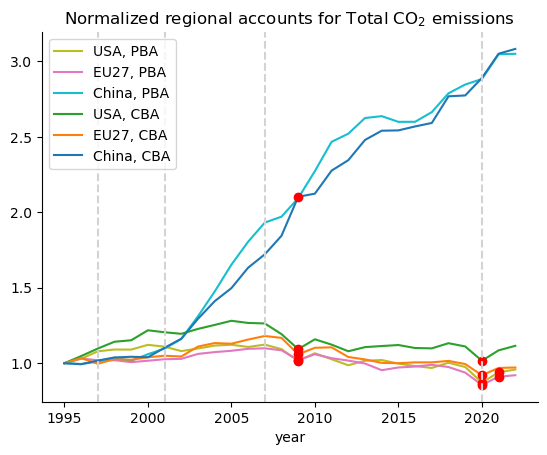

In [23]:
plot_norm_reg_footprint('Total CO2', CBAco2anoms, PBAco2anoms, 'Normalized regional accounts for Total CO$_2$ emissions')
plt.savefig('time_series_plots/fullCO2account')

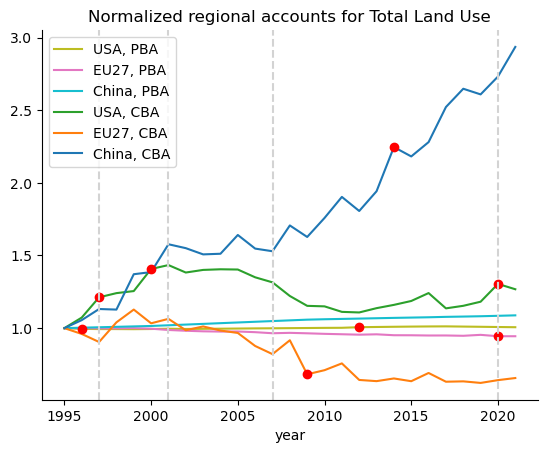

In [24]:
plot_norm_reg_footprint('Total Land Use', CBAlandanoms, PBAlandanoms, 'Normalized regional accounts for Total Land Use')
plt.savefig('time_series_plots/fullLandaccount')

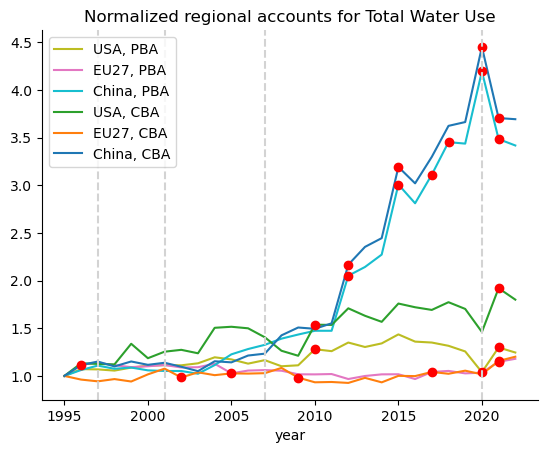

In [25]:
plot_norm_reg_footprint('Total Water Consumption Blue', CBAwateranoms, PBAwateranoms, 'Normalized regional accounts for Total Water Use')
plt.savefig('time_series_plots/fullWateraccount')

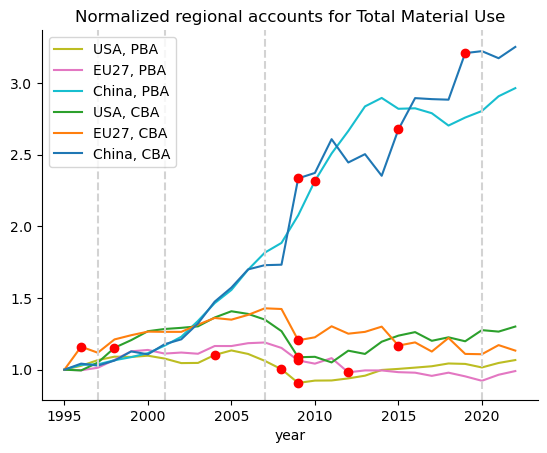

In [26]:
plot_norm_reg_footprint('Total Domestic Extraction Used', CBAmaterialanoms, PBAmaterialanoms, 'Normalized regional accounts for Total Material Use')
plt.savefig('time_series_plots/fullMaterialaccount')